# Analysing the Privacy Practices and GDPR Compliance of Mobile Health Apps

## Global Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as mtick
import seaborn as sns

import src.load_data as loader
import src.clean_data as cleaner
import src.find_pii as finder

In [3]:
font_dirs = ["./fonts/linux_libertine"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Linux Libertine'

## Load Data from SQLite Databases and JSON files

For this analysis, we use data from four sources:
- The self-declared data handling practices of the apps scraped from the Google Play Store's Data Safety page of each app.
- The traffic data collected by Heimdall during the automated crawl where each app was opened for 60 seconds without any user interaction.
- The traffic data collected by Heimdall during the 2024 manual crawl where we manually interacted with the apps to simulate a user's interactions, such as logging in, entering personal data, and using the app's features as far as possible to collect as much traffic data as possible.
- The traffic data collected by Heimdall during the 2022 manual crawl that was performed in the same way as the 2024 manual crawl.

The data is loaded using the `DataLoader` class from the `load_data` module, which loads the data from the SQLite databases and JSON files and provides the data in a structured format. To ensure consistency, we only load the data of apps that are present in all three traffic datasets.

In [4]:
dl = loader.DataLoader('data/automated_crawl.db', 'data/manual-crawl.db', 'data/data-handling.json', './data/manual-log.csv', './data/tracker-domains.txt')

apps = dl.apps
data_handling = dl.data_handling
traffic_auto_original = dl.traffic_auto
traffic_manual_original = dl.traffic_manual
third_party = dl.third_party
permissions = dl.permissions

## Clean Data

The first step is to clean the traffic data. We will remove binary data to speed up the analysis by focusing on plaintext content, replace base64 encoded data where possible, and URL decode the data. This will make it easier to search for PII in the traffic data. Since we're focusing on the analysis of PII leaving the device, we will also remove the response content from the traffic data to reduce the amount of data we need to process.

We're using the `clean_data` module for this step.

In [5]:
traffic_auto_clean = cleaner.clean_traffic(traffic_auto_original)
traffic_manual_clean = cleaner.clean_traffic(traffic_manual_original)

## Define Regular Expressions for PII Detection

We define regular expressions to detect PII in the traffic data. The regular expressions are grouped into categories based on the type of PII they detect. We use the following categories:
- Device Identifiers
- Location
- User Identifiers
- Fitness info
- Female health info
- Health info (medical)

### Device Identifiers
- Device model
- Screen resolution
- Carrier name
- OS build
- API level

In [6]:
r_did = [{'regex': re.compile(r'(?i)pixel.?6a|bluejay'), # Pixel 6A, Samsung Galaxy A13
          'name': 'Device model',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)\b1080\b'),
          'name': 'Resolution',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # screen width (height varies)
         {'regex': re.compile(r'(?i)nettokom'),
          'name': 'Carrier name',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # carrier name
         {'regex': re.compile(r'(?i)tp1a.220624.021.A1'),
          'name': 'OS build',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # OS build
         {'regex': re.compile(r'(?i)api.{1,15}33'),
          'name': 'API level',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'} # API level
         ]

### Location
- Locale
- Timezone
- Country
- Country code
- City
- Latitude
- Longitude

In [7]:
r_loc = [{'regex': re.compile(r'(?i)(?<!/)berlin'),
          'name': 'City',
          'category': 'Location',
          'ds_category': 'Approximate location',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)(52[\.,]5)\d*|(52[\.,]6)\d*'),
          'name': 'Latitude',
          'category': 'Location',
          'ds_category': 'Precise location',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)(13[\.,]3)\d*|(13[\.,]4)\d*'),
          'name': 'Longitude',
          'category': 'Location',
          'ds_category': 'Precise location',
          'specificity': 'Standard'}
         ]

### User Identifiers
- Name
- Email address
- Advertising ID
- Age
- Date of birth
- Gender

In [8]:
r_uid = [{'regex': re.compile(r'(?i)freya'), # first name is enough, we never entered the last name without it
          'name': 'Name',
          'category': 'User Info',
          'ds_category': 'Name',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)mhealthcrawl2024@gmail.com'),
          'name': 'Email address',
          'category': 'User Info',
          'ds_category': 'Email address',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)30f17059'),
          'name': 'Advertising ID',
          'category': 'User Info',
          'ds_category': 'User IDs',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)\bage.{0,20}?\b34\b'),
          'name': 'Age',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'}, # age
         {'regex': re.compile(r'(?i)\b1990\b|631234800239'),
          'name': 'Date of birth',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)female|gender'),
          'name': 'Gender',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'},
         ]

### Fitness info
- Body height
- Body weight
- Body weight goal
- BMI
- Step count
- Eating habits
- Fitness goals
- Fitness level
- Mental wellbeing
- Sleep habits

In [9]:
r_ufd = [{'regex': re.compile(r'(?i)height.{1,20}170|"value":"?170'),
          'name': 'Body height',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)w.{20}65|weight.{20}143|current.?weight|start.?weight|"value":"?65|\[65.0\]|"note":"65"'),
          'name': 'Body weight',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)weight.{1,20}60|w.{120}80|target.?weight|goal.?weight|weight.?goal'),
          'name': 'Body weight goal',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)[^u]bmi.{1,20}22'),
          'name': 'BMI',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)steps_goal|steps_progress|start_steps|"steps":5|step{1,20}271|goalStep'),
          'name': 'Step count',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)vegetarian|diet|drinkList'),
          'name': 'Eating habits',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)[^\.]lose.?weight[^\.]|[^\.]weight.{0,15}los[^\.]|diet.goal|main.goal|steps.goal|weight.change'),
          'name': 'Fitness goals',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)fitness.level|difficulty.{0,15}medium|level.{0,15}medium|beginner'),
          'name': 'Fitness level',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)stress|lack.?of.?sleep|forgetful'),
          'name': 'Mental wellbeing',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)sleep.?analysis|sleep.?quality|sleep.?hours|sleep.?time|"sleep":"between_5_and_6|lack.?of.?sleep|wake.?up.?time'),
          'name': 'Sleep habits',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'}
         ]

### Female health info
- Menstrual cycle length
- Period start date
- Period length
- Period symptoms
- Birth control

In [10]:
r_fhd = [{'regex': re.compile(r'(?i)cycle.{1,20}29'),
          'name': 'Cycle length',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)start.period|period.start|is_menstruation_began|cycle_day'),
          'name': 'Period start date',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)period.{1,20}5|duration_of_menstruation'),
          'name': 'Period length',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)acne|dysmenorrhea|discharge|cravings|mucus'),
          'name': 'Period symptoms',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)birth.control|contracept|pill.?record|pill.?count|pill.?date|vaginal_ring'),
          'name': 'Birth control',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'}
         ]

### Health info (medical)
- Sexual activity
- Body temperature
- Heart rate
- Blood pressure (systolic and diastolic)
- Glucose levels
- Medical conditions (diabetes, headache, allergies)

### Apply Regexes

Now, we apply the regexes to the traffic data to detect PII. The `apply_regexes` function applies the regexes to the `request_content` and `response_content` of the traffic data and writes the detected PII categories to a new column named `detected_pii`.

In [11]:
r_uhd = [
         {'regex': re.compile(r'(?i)is_made_love|sex.life|used_condom'),
          'name': 'Sexual activity',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)temp.{1,20}37|\[37.0\]|"note":"37"'),
          'name': 'Body temperature',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)rate.{1,20}70|puls.{1,20}70'),
          'name': 'Heart rate',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)diastolic|systolic|dia.{1,20}75|sys.{1,20}100'),
          'name': 'Blood pressure',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)glucose|[^\.]blood.?sugar[^\.]'),
          'name': 'Glucose levels',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)medical.cond|headache|[^\.]diabetes[^\.]|allerg'),
          'name': 'Medical conditions',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         ]

In [12]:
r_combined_all = r_did + r_loc + r_uid + r_ufd + r_fhd + r_uhd
r_combined_health = r_ufd + r_fhd + r_uhd

In [13]:
traffic_auto_regexed_all = finder.apply_regexes(traffic_auto_clean, r_combined_all)
traffic_manual_regexed_all = finder.apply_regexes(traffic_manual_clean, r_combined_all)
traffic_manual_regexed_health = finder.apply_regexes(traffic_manual_clean, r_combined_health)

The next step is to aggregate the PII by app. We will count the number of occurrences of each PII category for each app and merge the aggregated PII with the app information to create a DataFrame that contains all the information we need for the further analysis. We split this aggregation into two categories, distinguishing between PII that is transmitted to trackers and non-trackers.

In [14]:
traffic_auto_aggregated_non_tracker_all = finder.aggregate_pii_by_app(traffic_auto_regexed_all, r_combined_all, False)
traffic_manual_aggregated_non_tracker_all = finder.aggregate_pii_by_app(traffic_manual_regexed_all, r_combined_all, False)
traffic_manual_aggregated_non_tracker_health = finder.aggregate_pii_by_app(traffic_manual_regexed_health, r_combined_health, False)

In [15]:
traffic_auto_aggregated_tracker_all = finder.aggregate_pii_by_app(traffic_auto_regexed_all, r_combined_all, True)
traffic_manual_aggregated_tracker_all = finder.aggregate_pii_by_app(traffic_manual_regexed_all, r_combined_all, True)
traffic_manual_aggregated_tracker_health = finder.aggregate_pii_by_app(traffic_manual_regexed_health, r_combined_health, True)

Once the aggregation is complete for trackers and non-trackers, we merge them together for easier access and analysis.

In [16]:
traffic_auto_aggregated_all = traffic_auto_aggregated_tracker_all.merge(traffic_auto_aggregated_non_tracker_all, on='package_name', how='inner')
traffic_manual_aggregated_all = traffic_manual_aggregated_tracker_all.merge(traffic_manual_aggregated_non_tracker_all, on='package_name', how='inner')
traffic_manual_aggregated_health = traffic_manual_aggregated_tracker_health.merge(traffic_manual_aggregated_non_tracker_health, on='package_name', how='inner')

traffic_manual_aggregated_all

,package_name,detected_tracker_Device model,detected_tracker_Resolution,detected_tracker_Carrier name,detected_tracker_OS build,detected_tracker_API level,detected_tracker_City,detected_tracker_Latitude,detected_tracker_Longitude,detected_tracker_Name,...,detected_non_tracker_Period start date,detected_non_tracker_Period length,detected_non_tracker_Period symptoms,detected_non_tracker_Birth control,detected_non_tracker_Sexual activity,detected_non_tracker_Body temperature,detected_non_tracker_Heart rate,detected_non_tracker_Blood pressure,detected_non_tracker_Glucose levels,detected_non_tracker_Medical conditions
0,absworkout.bellyfatworkout.waistworkout.abdomi...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ai.replika.app,2,0,2,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,andrei.brusentcov.eye_exercises.free,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,app.meditasyon,5,1,3,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,armworkout.armworkoutformen.armexercises,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,splits.splitstraining.dothesplits.splitsin30days,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,steptracker.healthandfitness.walkingtracker.pe...,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,walking.weightloss.walk.tracker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,women.workout.female.fitness,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also aggregate the PII by remote host and domain to analyze the PII transmitted to specific domains. This allows us to identify prolific data collectors and potentially problematic levels of PII aggregation into third-party hands. For this step, we're omitting IP addresses to focus on resolvable host and domain names.

In [17]:
traffic_auto_regexed_filtered_all = traffic_auto_regexed_all[~traffic_auto_regexed_all['remote_host'].map(finder.is_ip_address)]
traffic_manual_regexed_filtered_all = traffic_manual_regexed_all[~traffic_manual_regexed_all['remote_host'].map(finder.is_ip_address)]
traffic_manual_regexed_filtered_health = traffic_manual_regexed_health[~traffic_manual_regexed_health['remote_host'].map(finder.is_ip_address)]

In [18]:
traffic_auto_hosts_all = finder.aggregate_pii_by_host(traffic_auto_regexed_all, r_combined_all)
traffic_manual_hosts_all = finder.aggregate_pii_by_host(traffic_manual_regexed_all, r_combined_all)
traffic_manual_hosts_health = finder.aggregate_pii_by_host(traffic_manual_regexed_health, r_combined_health)

traffic_manual_hosts_all

,remote_host,remote_domain,is_tracker,detected_Device model,detected_Resolution,detected_Carrier name,detected_OS build,detected_API level,detected_City,detected_Latitude,...,detected_Period start date,detected_Period length,detected_Period symptoms,detected_Birth control,detected_Sexual activity,detected_Body temperature,detected_Heart rate,detected_Blood pressure,detected_Glucose levels,detected_Medical conditions
0,02179913.akstat.io,akstat.io,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,104.16.76.186,104.16.76.186,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,104.18.13.192,104.18.13.192,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,104.18.31.195,104.18.31.195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,104.18.36.155,104.18.36.155,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,x.klarnacdn.net,klarnacdn.net,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177,xw73g4tb-android.mobile-messenger.intercom.com,intercom.com,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1178,yzapi.yazio.com,yazio.com,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1179,z.moatads.com,moatads.com,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
traffic_auto_domains_all = finder.aggregate_pii_by_domain(traffic_auto_regexed_filtered_all, r_combined_all)
traffic_manual_domains_all = finder.aggregate_pii_by_domain(traffic_manual_regexed_filtered_all, r_combined_all)
traffic_manual_domains_health = finder.aggregate_pii_by_domain(traffic_manual_regexed_filtered_health, r_combined_health)

traffic_manual_domains_all

,remote_domain,is_tracker,detected_Device model,detected_Resolution,detected_Carrier name,detected_OS build,detected_API level,detected_City,detected_Latitude,detected_Longitude,...,detected_Period start date,detected_Period length,detected_Period symptoms,detected_Birth control,detected_Sexual activity,detected_Body temperature,detected_Heart rate,detected_Blood pressure,detected_Glucose levels,detected_Medical conditions
0,130-149-223-32_s-2-16-164-104_ts-1709559537-cl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1384966836.rsc.cdn77.org,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1464501529.rsc.cdn77.org,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1925482343.rsc.cdn77.org,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2mdn.net,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,zdassets.com,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,zenadflow.com,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,zendesk.com,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393,zepp.com,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Data Safety

The Play Store's Data Safety page provides information about the data handling practices of the apps. We will use this information to categorise the apps based on their data handling practices and to analyze the relationship between the data handling practices and the PII transmitted by the apps.

As the data handling practices are provided in a JSON file, we will convert the JSON data to a structured format using the `data_safety_to_dataframe` function from the `find_pii` module and merge the data handling practices with the labeled and aggregated traffic data. The DataFrames resulting from this merge contain all the information we need for the further analysis.

First off, let's have a look at all the data safety types that are present in the data handling practices:

In [20]:
finder.aggregate_data_safety_types(data_handling)

{'Address',
 'App interactions',
 'Approximate location',
 'Calendar events',
 'Contacts',
 'Crash logs',
 'Device or other IDs',
 'Diagnostics',
 'Email address',
 'Emails',
 'Files and docs',
 'Fitness info',
 'Health info',
 'In-app search history',
 'Installed apps',
 'Music files',
 'Name',
 'Other actions',
 'Other app performance data',
 'Other audio files',
 'Other financial info',
 'Other in-app messages',
 'Other info',
 'Other user-generated content',
 'Phone number',
 'Photos',
 'Precise location',
 'Purchase history',
 'Race and ethnicity',
 'SMS or MMS',
 'Sexual orientation',
 'User IDs',
 'User payment info',
 'Videos',
 'Voice or sound recordings',
 'Web browsing history'}

And now we perform the merge:

In [21]:
data_safety_df = finder.data_safety_to_dataframe(data_handling)

traffic_auto_apps_all = traffic_auto_aggregated_all.merge(data_safety_df, left_on='package_name', right_on='pkg', how='inner')
traffic_auto_apps_all.drop('pkg', axis=1, inplace=True)
traffic_manual_apps_all = traffic_manual_aggregated_all.merge(data_safety_df, left_on='package_name', right_on='pkg', how='inner')
traffic_manual_apps_all.drop('pkg', axis=1, inplace=True)
traffic_manual_apps_health = traffic_manual_aggregated_health.merge(data_safety_df, left_on='package_name', right_on='pkg', how='inner')
traffic_manual_apps_health.drop('pkg', axis=1, inplace=True)

traffic_auto_apps_all

,package_name,detected_tracker_Device model,detected_tracker_Resolution,detected_tracker_Carrier name,detected_tracker_OS build,detected_tracker_API level,detected_tracker_City,detected_tracker_Latitude,detected_tracker_Longitude,detected_tracker_Name,...,shared_Name,shared_Other in-app messages,shared_Device or other IDs,shared_Other user-generated content,shared_Precise location,shared_Race and ethnicity,shared_Health info,shared_Address,shared_Other financial info,shared_In-app search history
0,absworkout.bellyfatworkout.waistworkout.abdomi...,1,0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,ai.replika.app,2,0,2,0,1,0,0,0,0,...,False,False,True,False,False,False,False,False,False,False
2,app.meditasyon,5,1,3,1,2,0,0,0,0,...,False,False,True,False,False,False,False,False,False,True
3,armworkout.armworkoutformen.armexercises,2,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,bloodpressure.bloodpressureapp.bloodpressuretr...,1,0,0,0,1,0,0,0,0,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,splits.splitstraining.dothesplits.splitsin30days,2,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
135,steptracker.healthandfitness.walkingtracker.pe...,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
136,walking.weightloss.walk.tracker,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
137,women.workout.female.fitness,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## Results

At this point we have aggregated the detected PII transmissions along three dimensions:
- by app: `traffic_auto_apps_all`, `traffic_manual_apps_all`, `traffic_manual_apps_health`
- by remote host: `traffic_auto_hosts_all`, `traffic_manual_hosts_all`, `traffic_manual_hosts_health`
- by domain: `traffic_auto_domains_all`, `traffic_manual_domains_all`, `traffic_manual_domains_health`

Time to analyse the data!

### Communication with Third-party Trackers

What are the apps that communicate with the most third-party trackers? We can find out by counting the number of distinct third-party trackers each app communicates with and then sorting the apps by this count.

In [22]:
traffic_manual_clean_filtered = traffic_manual_clean[traffic_manual_clean['is_tracker'].isin([0, 1])].merge(apps, on='package_name', how='inner')

# Group by 'package_name' and 'is_tracker', then count distinct 'remote_hosts'
result = traffic_manual_clean_filtered.groupby(['package_name', 'is_tracker']).agg(
    distinct_remote_hosts=('remote_host', 'nunique')
).reset_index()

# If you want to pivot the table for better readability, with separate columns for non-tracker and tracker counts
pivot_result = result.pivot_table(index='package_name', columns='is_tracker', values='distinct_remote_hosts', fill_value=0)

# add a column with the label of the app
pivot_result = pivot_result.merge(dl.apps[['package_name', 'label']], on='package_name', how='inner')
pivot_result.set_index('package_name', inplace=True)

pivot_result.columns = ['Non-tracker', 'Tracker', 'label']

top_20_packages = pivot_result.sort_values(by='Tracker', ascending=False).head(20)
top_20_packages = top_20_packages.sort_values(by='Tracker', ascending=True)

column_order = ['Tracker', 'Non-tracker', 'label']
top_20_packages = top_20_packages[column_order]
top_20_packages.set_index('label', inplace=True)

top_20_packages

,Tracker,Non-tracker
label,,
Splits Training in 30 Days,24.0,10.0
Step Counter - Pedometer,24.0,8.0
Push Ups Workout,25.0,4.0
Workout for Women: Fit at Home,25.0,9.0
My Days - Ovulation Calendar &,26.0,10.0
Blood Sugar Diary,27.0,6.0
Period Tracker & Ovulation,28.0,8.0
Running App - GPS Run Tracker,28.0,9.0
Arm Workout - Biceps Exercise,29.0,11.0


Which apps communicate with more trackers than non-trackers?

In [23]:
# filter pivot_result to only include packages where the tracker count is greater than the non-tracker count
more_trackers = pivot_result[pivot_result['Tracker'] > pivot_result['Non-tracker']]
more_trackers

,Non-tracker,Tracker,label
package_name,,,
absworkout.bellyfatworkout.waistworkout.abdominalworkout,4.0,10.0,Abs Workout - Burn Belly Fat
ai.replika.app,10.0,12.0,Replika
andrei.brusentcov.eye_exercises.free,1.0,10.0,Eye exercises
app.meditasyon,6.0,7.0,Meditopia: Sleep & Meditation
armworkout.armworkoutformen.armexercises,11.0,29.0,Arm Workout - Biceps Exercise
...,...,...,...
sixpack.sixpackabs.absworkout,8.0,16.0,Six Pack in 30 Days
softin.my.fast.fitness,5.0,6.0,Fitness & Bodybuilding
splits.splitstraining.dothesplits.splitsin30days,10.0,24.0,Splits Training in 30 Days


Which apps communicate exclusively with trackers?

In [24]:
# filter pivot_result to only include packages where the non-tracker count is 0 and the tracker count is greater than 0
no_non_trackers = pivot_result[(pivot_result['Non-tracker'] == 0) & (pivot_result['Tracker'] > 0)]
no_non_trackers

,Non-tracker,Tracker,label
package_name,,,
com.google.android.apps.fitness,0.0,2.0,Fit


On the other hand, which apps communicate exclusively with non-trackers?

In [25]:
# filter pivot_result to only include packages where the non-tracker count is 0 and the tracker count is greater than 0
no_trackers = pivot_result[(pivot_result['Tracker'] == 0) & (pivot_result['Non-tracker'] > 0)]
no_trackers

,Non-tracker,Tracker,label
package_name,,,
com.macropinch.hydra.android,19.0,0.0,Cardiograph
com.phycod.drugeye,9.0,0.0,DRUG EYE
com.urbandroid.lux,1.0,0.0,Twilight
net.klier.blutdruck,2.0,0.0,BloodPressureDB


Create a stacked bar chart to visualise the number of contacted hosts by each app, contrasting the number of contacted tracker and non-tracker hosts.

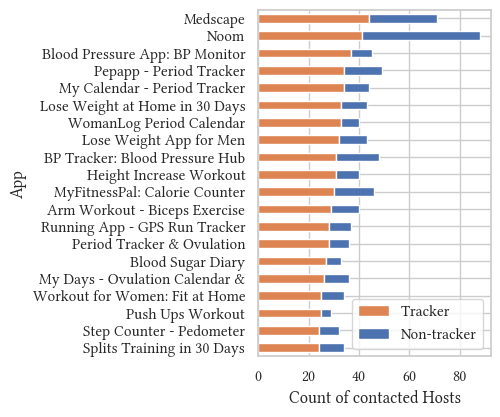

In [26]:
sns.set_theme(style='whitegrid', rc={'figure.figsize':(3,4.5)}, font='Linux Libertine')

# Creating a stacked bar chart
top_20_packages.plot(kind='barh', stacked=True, color=[sns.color_palette()[1], sns.color_palette()[0]])

# Adding titles and labels
plt.xlabel('Count of contacted Hosts')
plt.ylabel('App')

# Display the plot
import os
os.makedirs('./figures', exist_ok=True)
plt.savefig('./figures/contacted_hosts.pdf', bbox_inches="tight")

### PHI transmissions by PHI type

Now let's analyse the PII transmitted by the apps, focusing on the PHI types. For this, we count the number of occurrences of each PHI type for each app and merge the aggregated PHI with the app information to create a DataFrame that contains all the information we need for the further analysis.

In [27]:
t_a_a = traffic_auto_aggregated_all.copy()
t_m_a = traffic_manual_aggregated_all.copy()
pii_types_all = set(col.split('_')[-1] for col in t_a_a.columns if 'detected_' in col)
for pt in pii_types_all:
    t_a_a[pt] = t_a_a[f'detected_tracker_{pt}'] + t_a_a[f'detected_non_tracker_{pt}']
    t_m_a[pt] = t_m_a[f'detected_tracker_{pt}'] + t_m_a[f'detected_non_tracker_{pt}']
    t_a_a.drop([f'detected_tracker_{pt}', f'detected_non_tracker_{pt}'], axis=1, inplace=True)
    t_m_a.drop([f'detected_tracker_{pt}', f'detected_non_tracker_{pt}'], axis=1, inplace=True)
    t_a_a[pt] = t_a_a[pt].map(lambda x: bool(x))
    t_m_a[pt] = t_m_a[pt].map(lambda x: bool(x))
t_a_a = t_a_a.melt(id_vars=['package_name'], var_name='detected_type', value_name='transmitted')
t_m_a = t_m_a.melt(id_vars=['package_name'], var_name='detected_type', value_name='transmitted')

t_a_a['specificity'] = t_a_a['detected_type'].apply(lambda x: next(filter(lambda r: r['name'] == x, r_combined_all))['specificity'])
t_m_a['specificity'] = t_m_a['detected_type'].apply(lambda x: next(filter(lambda r: r['name'] == x, r_combined_all))['specificity'])
t_a_a = t_a_a.groupby(['package_name', 'specificity']).sum().reset_index().drop(['detected_type'], axis=1).rename(columns={'transmitted': 'Non-interactive'})
t_m_a = t_m_a.groupby(['package_name', 'specificity']).sum().reset_index().drop(['detected_type'], axis=1).rename(columns={'transmitted': 'Interactive'})
t_a_a['Non-interactive'] = t_a_a['Non-interactive'].map(lambda x: bool(x))
t_m_a['Interactive'] = t_m_a['Interactive'].map(lambda x: bool(x))
t_a_a = t_a_a.groupby('specificity').sum().drop(['package_name'], axis=1).reset_index()
t_m_a = t_m_a.groupby('specificity').sum().drop(['package_name'], axis=1).reset_index()

t_a_a.sort_values('specificity', inplace=True, key=lambda x: x.map({'Standard': 0, 'Nonstandard': 1, 'Medical': 2}))
t_m_a.sort_values('specificity', inplace=True, key=lambda x: x.map({'Standard': 0, 'Nonstandard': 1, 'Medical': 2}))

t_combined = t_a_a.merge(t_m_a, on='specificity', how='inner').melt(id_vars=['specificity'], var_name='dataset', value_name='transmitted')
t_combined['transmitted'] = t_combined['transmitted'] / len(dl.apps) * 100
t_combined['specificity'] = t_combined['specificity'].map({'Standard': 'Standard\nPII', 'Nonstandard': 'Nonstandard\nPHI', 'Medical': 'Medical\nPHI'})
t_combined

,specificity,dataset,transmitted
0,Standard\nPII,Non-interactive,70.394737
1,Nonstandard\nPHI,Non-interactive,6.578947
2,Medical\nPHI,Non-interactive,3.289474
3,Standard\nPII,Interactive,83.552632
4,Nonstandard\nPHI,Interactive,26.315789
5,Medical\nPHI,Interactive,17.763158


One of the big questions is whether the apps transmit more PHI when the user interacts with them. Let's compare the PHI transmissions by PHI specificity between the interactive and non-interactive crawl and visualise the results in a grouped bar chart.

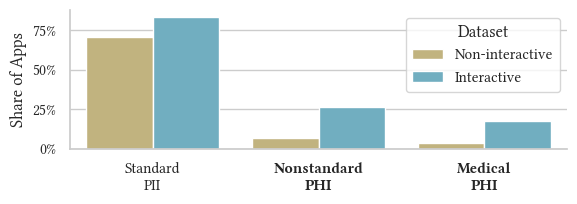

In [28]:
p_auto_vs_man = sns.catplot(
    x='specificity',
    y='transmitted',
    hue='dataset',
    data=t_combined,
    kind='bar',
    height=2.2,
    aspect=2,
    palette=sns.color_palette(sns.color_palette()[-2:]))

#p_auto_vs_man.fig.suptitle('Comparing PHI transmissions by PHI specificity between interactive and non-interactive crawl')
p_auto_vs_man.set_axis_labels('', 'Share of Apps')

# Remove the automatically generated legend
p_auto_vs_man._legend.remove()

# Create a custom legend
plt.legend(title='Dataset', loc='best')

for i, label in enumerate(p_auto_vs_man.ax.get_xticklabels()):
    if i in [1, 2]:
        label.set_weight('bold')
    else:
        label.set_weight('normal')
        
p_auto_vs_man.ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
plt.savefig('./figures/transmission_apps_specificities.pdf', bbox_inches="tight")

Next, we compare the PHI transmission volume by type, i.e. the number of apps that transmitted each PHI type to trackers and non-trackers. We visualise the results in a grouped bar chart.

In [29]:
traffic_manual_aggregated_health_bool = traffic_manual_aggregated_health.map(lambda x: x if not isinstance(x, int) else bool(x))
pii_types = set(col.split('_')[-1] for col in traffic_manual_aggregated_health_bool.columns if 'detected_' in col)

# Reshaping the DataFrame
melted_df_pii = pd.melt(traffic_manual_aggregated_health_bool, id_vars=['package_name'], var_name='detected_type', value_name='transmitted')

melted_df_pii['PII_type'] = melted_df_pii['detected_type'].apply(lambda x: x.split('_')[-1])
melted_df_pii['Host_type'] = melted_df_pii['detected_type'].apply(lambda x: 'Non-tracker' if 'non' in x else 'Tracker')

# Dropping the original 'detected_type' column as it's no longer needed
melted_df_pii.drop('detected_type', axis=1, inplace=True)

# Count the number of apps that transmitted each PII type to trackers and non-trackers
pii_counts = melted_df_pii.groupby(['PII_type', 'Host_type']).sum().reset_index().drop('package_name', axis=1)
order_list = list(map(lambda x: x['name'], r_combined_health))

pii_counts['PII_type'] = pd.Categorical(pii_counts['PII_type'], categories=order_list, ordered=True)
pii_counts.sort_values('PII_type', inplace=True)

# transform the counts to percentages
#pii_counts['transmitted'] = pii_counts['transmitted'] / len(dl.apps) * 100
pii_counts

,PII_type,Host_type,transmitted
6,Body height,Non-tracker,15
7,Body height,Tracker,5
11,Body weight,Tracker,5
10,Body weight,Non-tracker,12
13,Body weight goal,Tracker,7
12,Body weight goal,Non-tracker,16
0,BMI,Non-tracker,4
1,BMI,Tracker,3
40,Step count,Non-tracker,4
41,Step count,Tracker,2


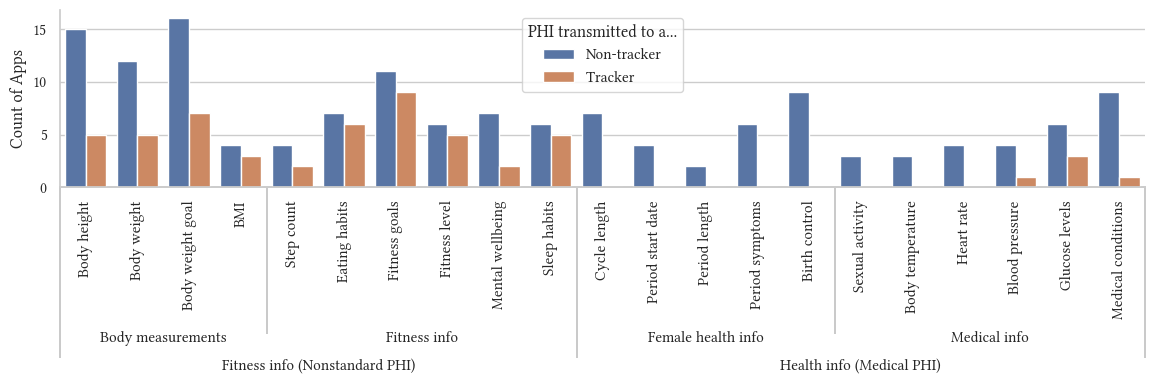

In [30]:
p_pii = sns.catplot(
    x='PII_type',
    y='transmitted',
    hue='Host_type',
    data=pii_counts,
    kind='bar',
    height=4,
    aspect=2.6)
plt.xticks(rotation=90)

#p_pii.fig.suptitle('PHI transmissions by PHI type, contrasting transmissions to tracker and non-tracker hosts')
p_pii.set_axis_labels('', 'Count of Apps')

#p_pii.ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Remove the automatically generated legend
p_pii._legend.remove()

# Create a custom legend
plt.legend(title='PHI transmitted to a...', loc='upper center')

# add a secondary x-axis below the first one to show the PHI type
ax2 = p_pii.ax.secondary_xaxis(location=0)
ax2.set_xticks([1.5, 6.5, 12, 17.5], labels=['Body measurements', 'Fitness info', 'Female health info', 'Medical info'])
ax2.tick_params('x', length=100, color='#ffffff', width=0)

ax4 = p_pii.ax.secondary_xaxis(location=0)
ax4.set_xticks([4.5, 15], labels=['Fitness info (Nonstandard PHI)', 'Health info (Medical PHI)'])
ax4.tick_params('x', length=120, color='#ffffff', width=0)

ax3 = p_pii.ax.secondary_xaxis(location=0)
ax3.set_xticks([3.5, 14.5], labels=[''] * 2)
ax3.tick_params('x', length=106, color='#c2c2c2')

ax5 = p_pii.ax.secondary_xaxis(location=0)
ax5.set_xticks([-0.5, 9.5, 20.5], labels=[''] * 3)
ax5.tick_params('x', length=123, color='#c2c2c2')

plt.tight_layout()

plt.savefig('./figures/transmission_apps_data_types.pdf', bbox_inches="tight")

## Comparison of received PII types by domain

Next question: which domains receive the most PII and PHI? We can find out by counting the number of occurrences of each PII category for each domain and then sorting the domains by this count. We also distinguish between PII transmitted to trackers and non-trackers to reveal the prevalence of PII and PHI transmission to third-party trackers.

In [31]:
# rename all columns starting with 'detected_' to remove that prefix
traffic_manual_domains_all.columns = traffic_manual_domains_all.columns.map(lambda x: x if not x.startswith('detected_') else x[9:])
# convert all int columns to bool
traffic_manual_domains_all['is_tracker'] = traffic_manual_domains_all['is_tracker'].map(lambda x: bool(x))
# add a colum that sums up all int columns
int_cols = traffic_manual_domains_all.select_dtypes(include='int64').columns
traffic_manual_domains_all['sum'] = traffic_manual_domains_all[int_cols].apply(lambda row: (row > 0).sum(), axis=1)
# sort by the sum column and filter out rows where is_tracker is False
domain_traffic = traffic_manual_domains_all[traffic_manual_domains_all['is_tracker']].sort_values('sum', ascending=False)
domain_traffic

,remote_domain,is_tracker,Device model,Resolution,Carrier name,OS build,API level,City,Latitude,Longitude,...,Period length,Period symptoms,Birth control,Sexual activity,Body temperature,Heart rate,Blood pressure,Glucose levels,Medical conditions,sum
36,amplitude.com,True,20,0,16,0,18,1,4,4,...,0,0,0,0,0,0,0,0,0,22
199,leanplum.com,True,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
186,iterable.com,True,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
114,facebook.com,True,36,0,16,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,7
352,tiktok.com,True,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,yahoo.com,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,yandex.net,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,yandexadexchange.net,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,youtube.com,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Embedded Third-party Trackers

Which third-party trackers are embedded in the apps? Heimdall can detect embedded third-party trackers by comparing the Java class names of examined apps with the Exodus database of known tracker libraries. Let's aggregate the results to find out which apps embed the most third-party trackers.

In [32]:
# count the occurrences of each package_name in third_party
third_party_counts = third_party.groupby('package_name').size().reset_index(name='count')
# count package_names that occur more than once
# get the average count from third_party_counts
third_party_counts

,package_name,count
0,absworkout.bellyfatworkout.waistworkout.abdomi...,3
1,ai.replika.app,6
2,andrei.brusentcov.eye_exercises.free,1
3,app.meditasyon,12
4,armworkout.armworkoutformen.armexercises,4
...,...,...
139,splits.splitstraining.dothesplits.splitsin30days,4
140,steptracker.healthandfitness.walkingtracker.pe...,6
141,walking.weightloss.walk.tracker,4
142,women.workout.female.fitness,6


Conversely, which third-party trackers are embedded in the most apps?

In [33]:
third_party.groupby('tracker_name').size().sort_values(ascending=False).reset_index(name='count')

,tracker_name,count
0,Google Firebase Analytics,137
1,Google CrashLytics,109
2,Google AdMob,102
3,Facebook Login,51
4,Facebook Ads,48
...,...,...
78,Tapstream,1
79,Split,1
80,fullstory,1
81,mParticle,1


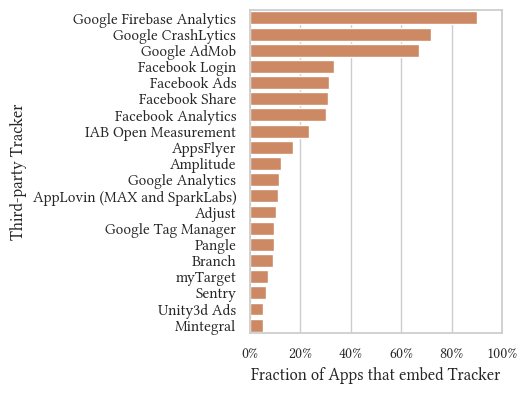

In [34]:
app_count = len(dl.apps)
count_3p = third_party.groupby('tracker_name').size().sort_values(ascending=False).reset_index(name='count')
count_3p['percentage'] = (count_3p['count'] / app_count) * 100
sns.set_theme(style='whitegrid', rc={'figure.figsize':(3.26,4.2)}, font='Linux Libertine')
p_3p = sns.barplot(
    data=count_3p.head(20),
    x='percentage',
    y='tracker_name',
    hue='tracker_name',
    legend=False,
    palette=sns.color_palette(sns.color_palette()[1:2] * 20)
)

#plt.suptitle('Prevalence of Embedded Third-party Trackers')
p_3p.set(xlabel='Fraction of Apps that embed Tracker', ylabel='Third-party Tracker')
p_3p.set(xlim=(0, 100))
p_3p.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('./figures/libraries.pdf', bbox_inches="tight")

## Observation vs Declaration

The Play Store's Data Safety page provides information about the data handling practices of the apps. We use this information to categorise the apps based on their data handling practices and to analyse the relationship between the data handling practices and the PII transmitted by the apps.

First, we group all entries of `r_combined_all` by `ds_category` and create a list of all `ds_category` values to use as a category list for the following analysis. Similarly, we group all entries of `r_combined_all` by `category` and create a list of all `category` values to use as a category list for the following analysis. 

In [35]:
# group all entries of r_combined_all by ds_category
ds_cat_map = {}
for r in r_combined_all:
    if r['ds_category'] not in ds_cat_map:
        ds_cat_map[r['ds_category']] = []
    ds_cat_map[r['ds_category']].append(r['name'])
ds_cat_map

{'Device or other IDs': ['Device model',
  'Resolution',
  'Carrier name',
  'OS build',
  'API level'],
 'Approximate location': ['City'],
 'Precise location': ['Latitude', 'Longitude'],
 'Name': ['Name'],
 'Email address': ['Email address'],
 'User IDs': ['Advertising ID'],
 'Other info': ['Age', 'Date of birth', 'Gender'],
 'Fitness info': ['Body height',
  'Body weight',
  'Body weight goal',
  'BMI',
  'Step count',
  'Eating habits',
  'Fitness goals',
  'Fitness level',
  'Mental wellbeing',
  'Sleep habits'],
 'Health info': ['Cycle length',
  'Period start date',
  'Period length',
  'Period symptoms',
  'Birth control',
  'Sexual activity',
  'Body temperature',
  'Heart rate',
  'Blood pressure',
  'Glucose levels',
  'Medical conditions']}

In [36]:
ds_cat_list = list(ds_cat_map.keys())
ds_cat_list

['Device or other IDs',
 'Approximate location',
 'Precise location',
 'Name',
 'Email address',
 'User IDs',
 'Other info',
 'Fitness info',
 'Health info']

In [37]:
# group all entries of r_combined_all by ds_category
cat_map = {}
for r in r_combined_all:
    if r['category'] not in cat_map:
        cat_map[r['category']] = []
    cat_map[r['category']].append(r['name'])
cat_map

{'Device IDs': ['Device model',
  'Resolution',
  'Carrier name',
  'OS build',
  'API level'],
 'Location': ['City', 'Latitude', 'Longitude'],
 'User Info': ['Name',
  'Email address',
  'Advertising ID',
  'Age',
  'Date of birth',
  'Gender'],
 'Body measurements': ['Body height',
  'Body weight',
  'Body weight goal',
  'BMI'],
 'Fitness info': ['Step count',
  'Eating habits',
  'Fitness goals',
  'Fitness level',
  'Mental wellbeing',
  'Sleep habits'],
 'Female health info': ['Cycle length',
  'Period start date',
  'Period length',
  'Period symptoms',
  'Birth control'],
 'Medical info': ['Sexual activity',
  'Body temperature',
  'Heart rate',
  'Blood pressure',
  'Glucose levels',
  'Medical conditions']}

In [38]:
cat_list = list(cat_map.keys())
cat_list

['Device IDs',
 'Location',
 'User Info',
 'Body measurements',
 'Fitness info',
 'Female health info',
 'Medical info']

Now we expand the `traffic_manual_apps_all` DataFrame to indicate whether the collection or sharing of a category was declared or undeclared. We then reshape the DataFrame to long format and create a catplot to visualise the results.   

In [39]:
trf = traffic_manual_apps_all.copy()
trf.columns = trf.columns.map(lambda x: x if not x.startswith('detected_') else x[9:])
trf = trf.map(lambda x: x if not isinstance(x, int) else bool(x))

# iterate through cat_map and add columns indicating whether the collection or sharing of a category was declared or undeclared
for cat, names in ds_cat_map.items():
    trf[f'tracker_cat_{cat}'] = trf[[f'tracker_{name}' for name in names]].sum(axis=1)
    trf[f'non_tracker_cat_{cat}'] = trf[[f'non_tracker_{name}' for name in names]].sum(axis=1)
    trf[f'tracker_cat_{cat}'] = trf[f'tracker_cat_{cat}'].map(lambda x: bool(x))
    trf[f'non_tracker_cat_{cat}'] = trf[f'non_tracker_cat_{cat}'].map(lambda x: bool(x))
    trf.drop([f'tracker_{name}' for name in names], axis=1, inplace=True)
    trf.drop([f'non_tracker_{name}' for name in names], axis=1, inplace=True)
    trf[f'declared_collected_{cat}'] = (trf[f'tracker_cat_{cat}'] + trf[f'non_tracker_cat_{cat}']) & trf[f'collected_{cat}']
    trf[f'undeclared_collected_{cat}'] = (trf[f'tracker_cat_{cat}'] + trf[f'non_tracker_cat_{cat}']) & ~trf[f'collected_{cat}']
    trf[f'declared_shared_{cat}'] = trf[f'tracker_cat_{cat}'] & trf[f'shared_{cat}']
    trf[f'undeclared_shared_{cat}'] = trf[f'tracker_cat_{cat}'] & ~trf[f'shared_{cat}']
trf

,package_name,data_deletable,data_encrypted,independently_reviewed,collected_Email address,collected_Approximate location,collected_Calendar events,collected_User IDs,collected_Crash logs,collected_Diagnostics,...,declared_collected_Fitness info,undeclared_collected_Fitness info,declared_shared_Fitness info,undeclared_shared_Fitness info,tracker_cat_Health info,non_tracker_cat_Health info,declared_collected_Health info,undeclared_collected_Health info,declared_shared_Health info,undeclared_shared_Health info
0,absworkout.bellyfatworkout.waistworkout.abdomi...,True,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,ai.replika.app,True,True,False,True,False,False,False,True,True,...,False,True,False,False,False,False,False,False,False,False
2,andrei.brusentcov.eye_exercises.free,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,app.meditasyon,True,True,False,True,False,False,False,True,True,...,True,False,False,True,False,False,False,False,False,False
4,armworkout.armworkoutformen.armexercises,True,True,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,splits.splitstraining.dothesplits.splitsin30days,True,True,False,True,False,False,False,True,True,...,True,False,False,False,False,False,False,False,False,False
140,steptracker.healthandfitness.walkingtracker.pe...,True,True,False,False,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
141,walking.weightloss.walk.tracker,True,True,False,False,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
142,women.workout.female.fitness,True,True,False,True,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [40]:
# drop all boolean columns not beginning with 'declared_' or 'undeclared_'
trf_small = trf[[col for col in trf.columns if col.startswith('declared_') or col.startswith('undeclared_') or col == 'package_name']]

# shorten the prefixes
trf_small.columns = trf_small.columns.map(lambda x: x.replace('_collected_', '_c_').replace('_shared_', '_s_'))
trf_small.columns = trf_small.columns.map(lambda x: x.replace('undeclared_', 'u_').replace('declared_', 'd_'))
trf_small.columns = trf_small.columns.map(lambda x: x.replace('u_c', 'Undeclared collection').replace('d_c', 'Declared collection'))
trf_small.columns = trf_small.columns.map(lambda x: x.replace('u_s', 'Undeclared sharing').replace('d_s', 'Declared sharing'))

# reshape the DataFrame to long format
trf_small = trf_small.melt(id_vars=['package_name'], var_name='detected_type', value_name='count')

# add a column 'hue' for the prefix and remove the prefix from detected_type
trf_small['hue'] = trf_small['detected_type'].map(lambda x: x.split('_')[0])
# remove the prefix from detected_type (i.e. everything before the first underscore)
trf_small['detected_type'] = trf_small['detected_type'].map(lambda x: x.split('_')[1])
trf_small

,package_name,detected_type,count,hue
0,absworkout.bellyfatworkout.waistworkout.abdomi...,Device or other IDs,True,Declared collection
1,ai.replika.app,Device or other IDs,True,Declared collection
2,andrei.brusentcov.eye_exercises.free,Device or other IDs,False,Declared collection
3,app.meditasyon,Device or other IDs,True,Declared collection
4,armworkout.armworkoutformen.armexercises,Device or other IDs,True,Declared collection
...,...,...,...,...
5179,splits.splitstraining.dothesplits.splitsin30days,Health info,False,Undeclared sharing
5180,steptracker.healthandfitness.walkingtracker.pe...,Health info,False,Undeclared sharing
5181,walking.weightloss.walk.tracker,Health info,False,Undeclared sharing
5182,women.workout.female.fitness,Health info,False,Undeclared sharing


In [41]:
# group by detected_type and hue and sum the transmitted column
trf_small_grouped = trf_small.groupby(['detected_type', 'hue']).sum().reset_index().drop(['package_name'], axis=1)
trf_small_grouped['detected_type'] = pd.Categorical(trf_small_grouped['detected_type'], categories=ds_cat_list, ordered=True)

# replace the first space character that comes after 8 characters with a newline character, leave all other space characters as they are
trf_small_grouped['detected_type'] = trf_small_grouped['detected_type'].map(lambda x: re.sub(r'(?<=.{8}) ', '\n', x, count=1))
# rename 'hue' to 'Transparency of data practices'
trf_small_grouped.rename(columns={'hue': 'Transparency of data practices'}, inplace=True)
trf_small_grouped['count'] = trf_small_grouped['count'] / len(dl.apps) * 100

trf_small_grouped

,detected_type,Transparency of data practices,count
0,Approximate\nlocation,Declared collection,1.973684
1,Approximate\nlocation,Declared sharing,0.657895
2,Approximate\nlocation,Undeclared collection,3.289474
3,Approximate\nlocation,Undeclared sharing,0.000000
4,Device or\nother IDs,Declared collection,61.842105
5,Device or\nother IDs,Declared sharing,33.552632
6,Device or\nother IDs,Undeclared collection,20.394737
7,Device or\nother IDs,Undeclared sharing,43.421053
8,Email address,Declared collection,20.394737
9,Email address,Declared sharing,5.263158


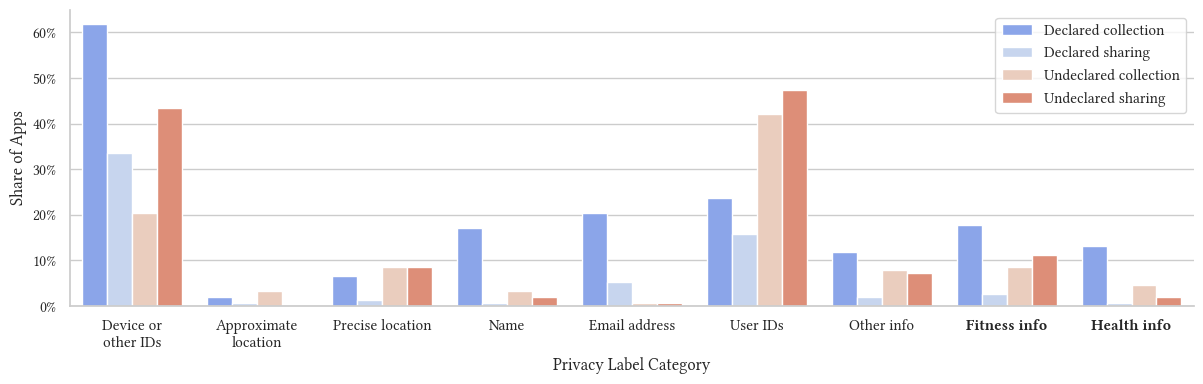

In [42]:
# create a catplot for trf_small_grouped where the x-axis values are in the same order as ds_cat_list
p_trf_small = sns.catplot(
    x='detected_type',
    y='count',
    hue='Transparency of data practices',
    data=trf_small_grouped,
    kind='bar',
    height=4,
    aspect=2.5,
    palette='coolwarm'
)

#p_trf_small.fig.suptitle('Accuracy of Google Play Privacy Labels in Reflecting mHealth Data Practices')
p_trf_small.set_axis_labels('Privacy Label Category', 'Share of Apps')

p_trf_small.ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# remove legend title
p_trf_small._legend.set_title('')

# Remove the automatically generated legend
p_trf_small._legend.remove()

# Create a custom legend
plt.legend(loc='best')

# write the last two x-axis labels in bold, all others normally
for i, label in enumerate(p_trf_small.ax.get_xticklabels()):
    if i in [len(ds_cat_list) - 2, len(ds_cat_list) - 1]:
        label.set_weight('bold')
    else:
        label.set_weight('normal')
        
plt.tight_layout()
plt.savefig('./figures/observation_vs_declaration.pdf', bbox_inches="tight")

## Observation vs. Expectation

Dehling et al.'s mHealth app archetype framework provides a categorisation of expected PHI specificity for mHealth apps. We will use this information to categorise the apps based on their expected PHI specificity and to analyse the relationship between the expected PHI specificity and the actual PHI transmitted by the apps.

First, let's figure out which of the three PHI specificities each app transmitted.

In [43]:
t_m_a2 = traffic_manual_aggregated_all.copy()
pii_types_all2 = set(col.split('_')[-1] for col in t_m_a2.columns if 'detected_' in col)
for pt in pii_types_all2:
    t_m_a2[pt] = t_m_a2[f'detected_tracker_{pt}'] + t_m_a2[f'detected_non_tracker_{pt}']
    t_m_a2.drop([f'detected_tracker_{pt}', f'detected_non_tracker_{pt}'], axis=1, inplace=True)
    t_m_a2[pt] = t_m_a2[pt].map(lambda x: bool(x))
t_m_a2 = t_m_a2.melt(id_vars=['package_name'], var_name='detected_type', value_name='transmitted')

t_m_a2['specificity'] = t_m_a2['detected_type'].apply(lambda x: next(filter(lambda r: r['name'] == x, r_combined_all))['specificity'])
t_m_a2 = t_m_a2.groupby(['package_name', 'specificity']).sum().reset_index().drop(['detected_type'], axis=1)
t_m_a2['transmitted'] = t_m_a2['transmitted'].map(lambda x: bool(x))
t_m_a3 = t_m_a2.groupby('specificity').sum().drop(['package_name'], axis=1).reset_index()

t_m_a3.sort_values('specificity', inplace=True, key=lambda x: x.map({'Standard': 0, 'Nonstandard': 1, 'Medical': 2}))
t_m_a2

,package_name,specificity,transmitted
0,absworkout.bellyfatworkout.waistworkout.abdomi...,Medical,False
1,absworkout.bellyfatworkout.waistworkout.abdomi...,Nonstandard,False
2,absworkout.bellyfatworkout.waistworkout.abdomi...,Standard,True
3,ai.replika.app,Medical,False
4,ai.replika.app,Nonstandard,True
...,...,...,...
427,women.workout.female.fitness,Nonstandard,False
428,women.workout.female.fitness,Standard,True
429,workoutforwomen.femalefitness.womenworkout.los...,Medical,False
430,workoutforwomen.femalefitness.womenworkout.los...,Nonstandard,True


Next, we group the apps by their feature category and 

In [44]:
# unmelt t_m_a2
t_m_a4 = t_m_a2.pivot(index='package_name', columns='specificity', values='transmitted').reset_index()

# merge t_m_a4 with apps
t_m_a5 = t_m_a4.merge(apps, on='package_name', how='inner')

# transform the columns 'Standard', 'Nonstandard' and 'Medical' to a single column 'observed'
t_m_a5['observed'] = t_m_a5['Standard'].map(lambda x: 'Standard' if x else 'None')
t_m_a5['observed'] = t_m_a5.apply(lambda row: 'Nonstandard' if row['Nonstandard'] else row['observed'], axis=1)
t_m_a5['observed'] = t_m_a5.apply(lambda row: 'Medical' if row['Medical'] else row['observed'], axis=1)
t_m_a5['observed'] = pd.Categorical(t_m_a5['observed'], categories=['None', 'Standard', 'Nonstandard', 'Medical'], ordered=True)
t_m_a5['specificity'] = pd.Categorical(t_m_a5['specificity'], categories=['None', 'Standard', 'Nonstandard', 'Medical'], ordered=True)

# drop all columns except 'package_name', 'observed' and 'specificity'
t_m_a6 = t_m_a5[['package_name', 'feature_category', 'observed', 'specificity']]

t_m_a6

,package_name,feature_category,observed,specificity
0,absworkout.bellyfatworkout.waistworkout.abdomi...,Workout Guide,Standard,Nonstandard
1,ai.replika.app,Mental Wellbeing,Nonstandard,Nonstandard
2,andrei.brusentcov.eye_exercises.free,Workout Guide,Standard,Nonstandard
3,app.meditasyon,Mental Wellbeing,Nonstandard,Nonstandard
4,armworkout.armworkoutformen.armexercises,Workout Guide,Standard,Nonstandard
...,...,...,...,...
139,splits.splitstraining.dothesplits.splitsin30days,Workout Guide,Nonstandard,Nonstandard
140,steptracker.healthandfitness.walkingtracker.pe...,Cardio Tracker,Standard,Nonstandard
141,walking.weightloss.walk.tracker,Cardio Tracker,None,Nonstandard
142,women.workout.female.fitness,Workout Guide,Standard,Nonstandard


In [45]:
specificity_order = {'None': 0, 'Standard': 1, 'Nonstandard': 2, 'Medical': 3}

# Mapping observed specificity to numerical values for comparison
t_m_a6['observed_rank'] = t_m_a6['observed'].map(specificity_order)

# Grouping by 'feature_category' and finding the highest observed specificity
result = t_m_a6.groupby('feature_category')['observed_rank'].max().reset_index()

# Mapping back to specificity labels
result['highest_observed_specificity'] = result['observed_rank'].map({v: k for k, v in specificity_order.items()})

# Selecting the required columns for the final result
result = result[['feature_category', 'highest_observed_specificity']]

result

C:\Users\johan\AppData\Local\Temp\ipykernel_17116\567613224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_m_a6['observed_rank'] = t_m_a6['observed'].map(specificity_order)


,feature_category,highest_observed_specificity
0,Cardio Tracker,Nonstandard
1,Diagnostic,Standard
2,Diet Tracker,Medical
3,Female Health,Medical
4,Health Education,Nonstandard
5,Health Monitor,Medical
6,Mental Wellbeing,Nonstandard
7,Pharmacy,Nonstandard
8,Physician Finder,Standard
9,Screen Overlay,Standard


In [46]:
feature_categories = ['Screen Overlay', 'Health Education', 'Step Counter', 'Workout Guide', 'Cardio Tracker', 'Diet Tracker', 'Wearable', 'Mental Wellbeing', 'Pharmacy', 'Physician Finder', 'Female Health', 'Diagnostic', 'Health Monitor', 'Telemedicine']

t_cats = traffic_manual_aggregated_all.copy()
pii_types_all2 = set(col.split('_')[-1] for col in t_cats.columns if 'detected_' in col)
for pt in pii_types_all2:
    t_cats[pt] = t_cats[f'detected_tracker_{pt}'] + t_cats[f'detected_non_tracker_{pt}']
    t_cats.drop([f'detected_tracker_{pt}', f'detected_non_tracker_{pt}'], axis=1, inplace=True)
    t_cats[pt] = t_cats[pt].map(lambda x: bool(x))
t_cats = t_cats.melt(id_vars=['package_name'], var_name='detected_type', value_name='transmitted')

t_cats['category'] = t_cats['detected_type'].apply(lambda x: next(filter(lambda r: r['name'] == x, r_combined_all))['category'])
t_cats = t_cats.groupby(['package_name', 'category']).sum().reset_index().drop(['detected_type'], axis=1)
t_cats['transmitted'] = t_cats['transmitted'].map(lambda x: bool(x))
t_cats = t_cats.pivot(index='package_name', columns='category', values='transmitted').reset_index()
t_cats = t_cats.merge(apps, on='package_name', how='inner')
t_cats = t_cats[['package_name', 'feature_category'] + cat_list]

t_cats_grouped = t_cats.groupby('feature_category').sum().reset_index()
t_cats_grouped.drop('package_name', axis=1, inplace=True)
t_cats_grouped['feature_category'] = pd.Categorical(t_cats_grouped['feature_category'], categories=feature_categories, ordered=True)
t_cats_grouped.sort_values('feature_category', inplace=True)
t_cats_grouped.rename(columns={'feature_category': 'Feature Category'}, inplace=True)
t_cats_grouped

,Feature Category,Device IDs,Location,User Info,Body measurements,Fitness info,Female health info,Medical info
9,Screen Overlay,2,1,2,0,0,0,0
4,Health Education,9,1,7,2,0,0,0
10,Step Counter,4,1,4,1,1,0,1
13,Workout Guide,25,1,25,7,10,0,1
0,Cardio Tracker,12,3,12,1,1,0,0
2,Diet Tracker,12,5,10,6,5,0,3
12,Wearable,2,0,1,1,1,0,1
6,Mental Wellbeing,6,0,5,1,5,0,0
7,Pharmacy,5,2,4,1,0,0,0
8,Physician Finder,1,1,1,0,0,0,0


For each detected PII and PHI type, what is the ratio of undeclared and declared transmissions? We calculate this ratio for both collection and sharing of data.

In [47]:
ratios = trf_small_grouped.pivot(index='detected_type', columns='Transparency of data practices', values='count')

# calculate the ratio of declared to undeclared transmissions for each detected type
ratios['ratio_col'] = ratios['Undeclared collection'] / (ratios['Declared collection'] + ratios['Undeclared collection']) * 100
ratios['ratio_sh'] = ratios['Undeclared sharing'] / (ratios['Declared sharing'] + ratios['Undeclared sharing']) * 100

ratios[['ratio_col', 'ratio_sh']]

Transparency of data practices,ratio_col,ratio_sh
detected_type,,
Device or\nother IDs,24.800000,56.410256
Approximate\nlocation,62.500000,0.000000
Precise location,56.521739,86.666667
Name,16.129032,75.000000
Email address,3.125000,11.111111
User IDs,64.000000,75.000000
Other info,40.000000,78.571429
Fitness info,32.500000,80.952381
Health info,25.925926,75.000000


### Other Statistics that are relevant for the paper

How many unique domains do we have in the data (excluding IP addresses)?

In [48]:
# count all unique values of `remote_domain` that are not an IP address
len(traffic_manual_clean[~traffic_manual_clean['remote_domain'].map(finder.is_ip_address)]['remote_domain'].unique())

395

How many unique third-party tracker hosts do we have in the data?

In [49]:
# count all unique values of 'remote_host' that are trackers
len(traffic_manual_clean['remote_host'].unique())

1181

How many unique third-party tracker domains do we have in the data?

In [50]:
# count all unique values of 'remote_domain' that are trackers
len(traffic_manual_clean[traffic_manual_clean['is_tracker'] == 1]['remote_domain'].unique())

132

In [51]:
# get the top 20 domains that are trackers, counting the number of distinct apps that contacted them (not the number of requests)
traffic_manual_clean[traffic_manual_clean['is_tracker'] == 1].groupby('remote_domain')['package_name'].nunique().sort_values(ascending=False).head(20)

remote_domain
crashlytics.com                         105
gstatic.com                              88
doubleclick.net                          84
facebook.com                             78
google.com                               70
googlesyndication.com                    67
googleusercontent.com                    67
googletagservices.com                    66
googleadservices.com                     58
firebaselogging.googleapis.com           47
amplitude.com                            20
appsflyersdk.com                         18
adjust.com                               16
crashlyticsreports-pa.googleapis.com     15
period-calendar.com                      14
2mdn.net                                 12
liftoff-creatives.io                     10
appsflyer.com                            10
adform.net                               10
branch.io                                 9
Name: package_name, dtype: int64

How many requests with a non-empty body do we have in the data?

In [52]:
# count all requests with a non-empty 'request_content' column
len(traffic_manual_regexed_all[traffic_manual_regexed_all['request_content'].map(lambda x: bool(x))]['request_content'])

7178